                                                Dealiasing
                                               Zach Sherman
                                          Argonne National Laboratory

In [1]:
#Import Modules
import pyart
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
from io import StringIO
from boto.s3.connection import S3Connection
import shutil, os, sys
import gzip
import pylab as plb
import matplotlib as mpl
import numpy.ma as ma
from pylab import *
#print(pyart.__version__)

/home/zsherman/anaconda3/lib/python3.5/site-packages/pyart/map/grid_mapper.py:40: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  from .ball_tree import BallTree
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1=

In [2]:
conn = S3Connection(anon=True)
bucket = conn.get_bucket('testradar')
for key in bucket.list():
    print (key.name.encode('utf-8'))
#CPOL (C-band Polarimetric Radar)

b'CSU_unfolded/'
b'CSU_unfolded/CPOL_corr_20060122_140009_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_141010_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_142009_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_143009_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_144009_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_145009_vt_unfolded_hand.cfrad.nc.gz'
b'zindex.png'


In [3]:
#gzip and opening CPOL files
LOCAL_PATH = '/home/zsherman/Documents/Jupyter/'
filenames = []
bucket_list = bucket.list()
for l in bucket_list:
    keyString = str(l.key)
    print(keyString)
    if '.gz' in keyString:
        l.get_contents_to_filename(LOCAL_PATH+keyString)
        filenames.append(LOCAL_PATH+keyString[0:-3])
        gzfh = gzip.open(LOCAL_PATH+keyString, 'rb')
        ofh = open(LOCAL_PATH+keyString[0:-3], 'wb')
        for line in gzfh:
            ofh.write(line)
        ofh.close()
        gzfh.close()
        os.remove(LOCAL_PATH+keyString)

CSU_unfolded/
CSU_unfolded/CPOL_corr_20060122_140009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_141010_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_142009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_143009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_144009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_145009_vt_unfolded_hand.cfrad.nc.gz
zindex.png


In [4]:
#Reading all files with pyart
radar_files = []
for filename in filenames:
    radar_files += [pyart.io.read(filename)]

In [5]:
#Using pyarts region deliasing to correct outliers.
def corrected_velocity_region(radar):
    sw_sel = 0
    sw_num = radar.nsweeps
    sw_elevs = [radar.fixed_angle['data'][sw] for sw in range(0, sw_num-1)]
    el_sel = sw_elevs[sw_sel]
    
    gatefilter = pyart.correct.GateFilter(radar)
    corr_vel_region = pyart.correct.dealias_region_based(
    radar, vel_field='velocity', keep_original=False, 
    gatefilter = gatefilter, nyquist_vel=ny_vel, centered = True)
    radar.add_field('corrected_velocity_region', corr_vel_region, replace_existing = True)

In [6]:
#Defining and displaying reflectivity field for all files.
def reflectivity_fields(radar):
    dZ = radar.fields['reflectivity']['data']
    dZ_mean = ma.mean(dZ)
    dZ_std = ma.std(dZ)
    dZ_max = ma.max(dZ)
    indxs = ma.where(dZ == ma.max(dZ))

    print('Statistics of reflectivity field: %.0f' % (dZ_mean) + " +/- " + '%.0f' % (dZ_std))

In [8]:
#Function if needed to display all velocity data
def velocity_data(radar):
    velocity = ma.asanyarray(radar.fields['velocity']['data'])
    print ("Velocity")
    return velocity

In [9]:
#Function if needed to display all corrected velocity data
def corrected_velocity_data(radar):
    cv_attribute_name = ''
    if ('corrected_velocity' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity'
    elif ('corrected_velocity2' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity2'
    else:
        raise Exception('key not found')
    corrected_velocity = ma.asanyarray(radar.fields[cv_attribute_name]['data'])
    print("Corrected Velocity")
    return corrected_velocity

Statistics of reflectivity field: 22 +/- 9


/home/zsherman/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/zsherman/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


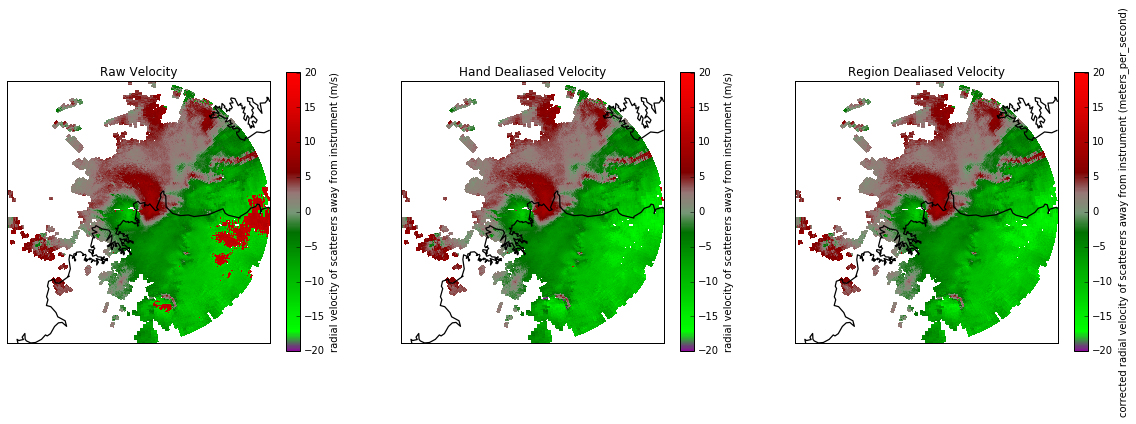

Statistics of reflectivity field: 23 +/- 9


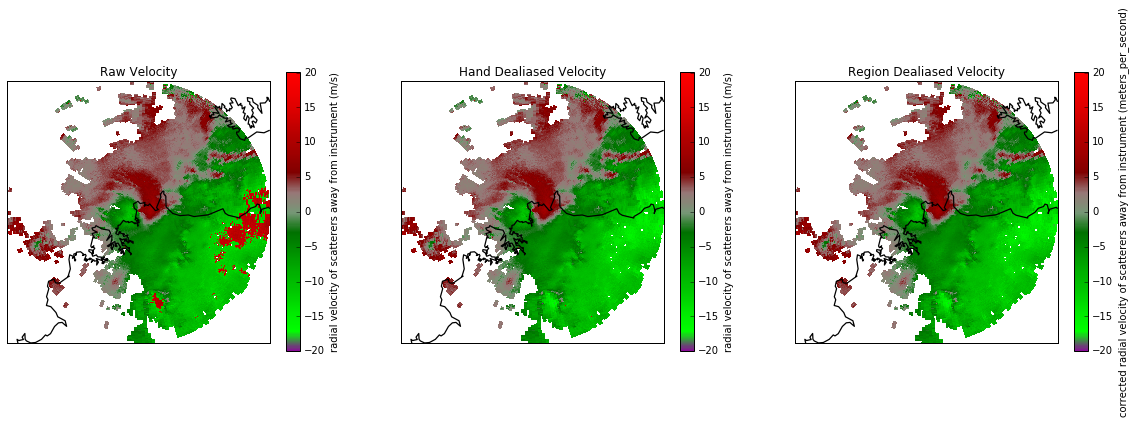

Statistics of reflectivity field: 21 +/- 9


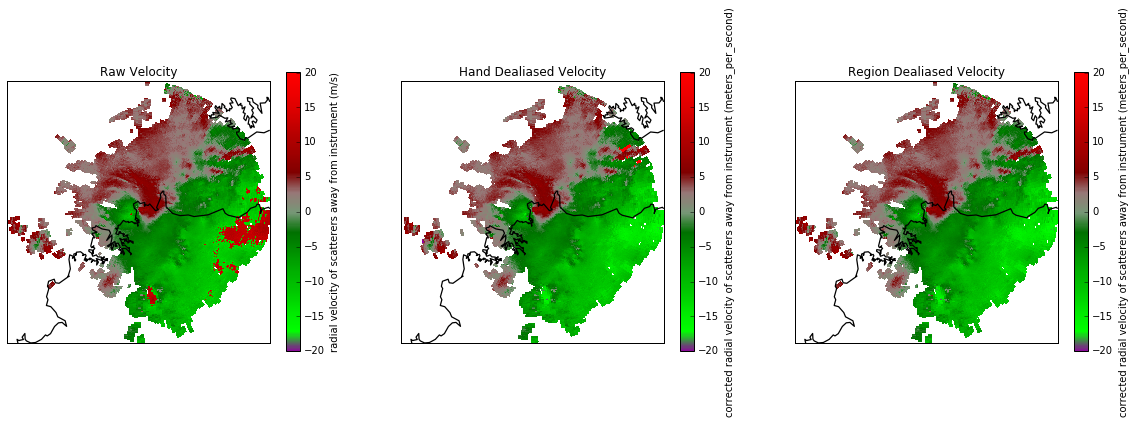

Statistics of reflectivity field: 23 +/- 9


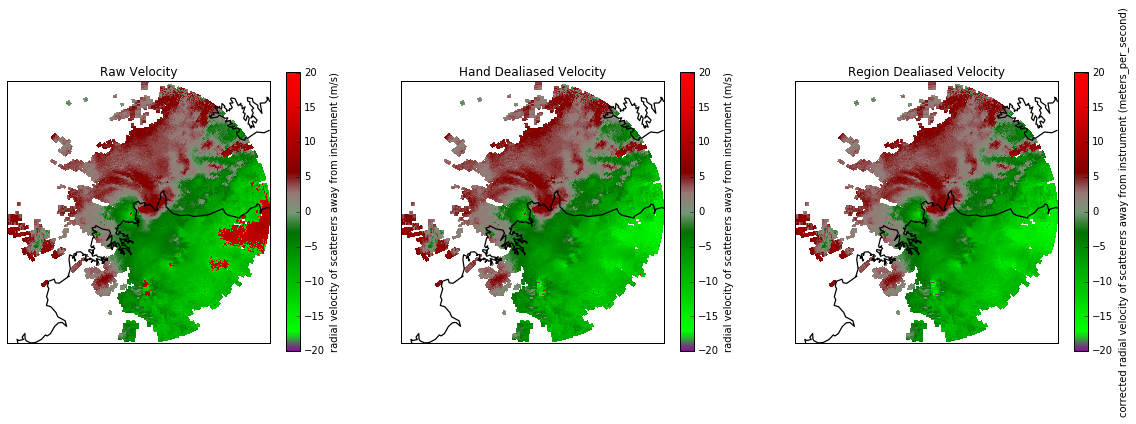

Statistics of reflectivity field: 23 +/- 9


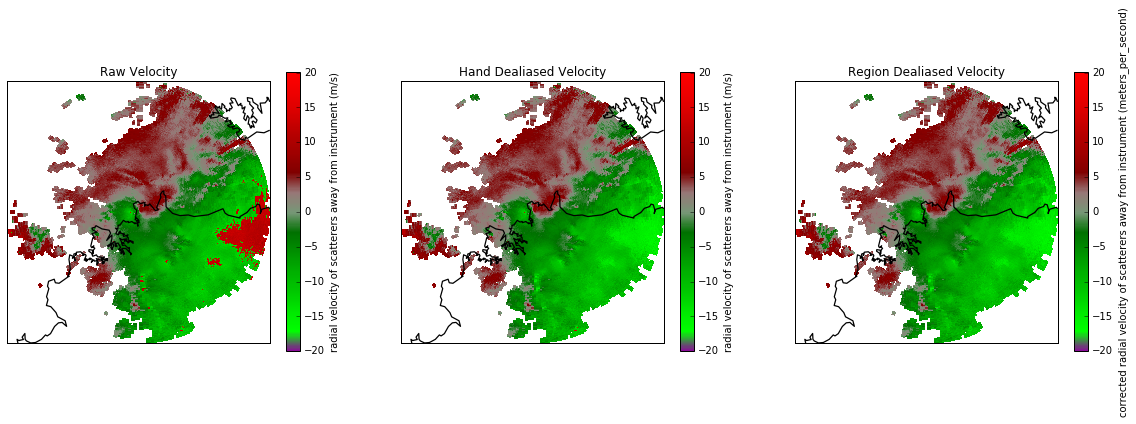

Statistics of reflectivity field: 23 +/- 9


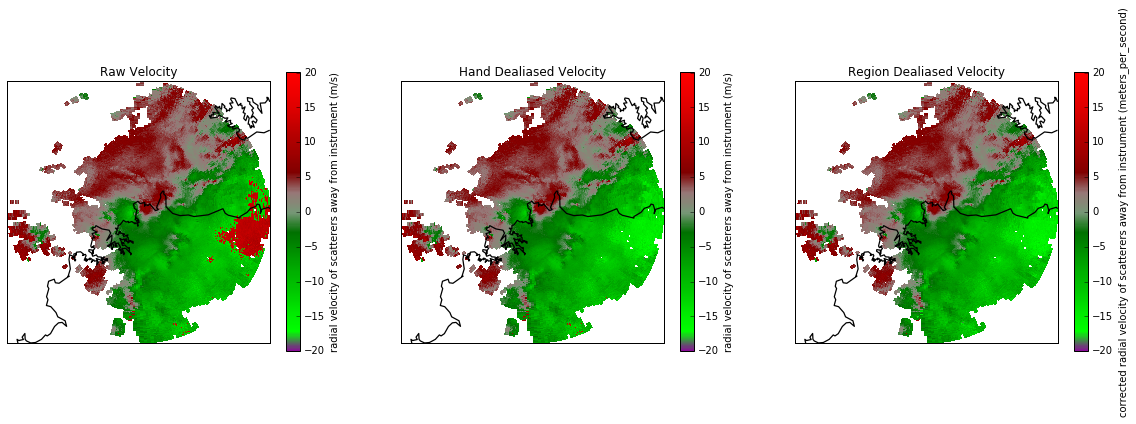

In [11]:
#Reading all files with pyart
#Plotting the raw velocity data for all files.
out_path = '/home/zsherman/Documents/Jupyter/CSU_unfolded/Images/Comparison/'
d_cmap = cm.get_cmap('PiYG', 11)
for radar_file in radar_files:
    radar_file.extract_sweeps([0, 3])
    ny_vel = radar_file.instrument_parameters['nyquist_velocity']['data'][0]
    corrected_velocity_region(radar_file)
    reflectivity_fields(radar_file)
    
    sw_sel = 0
    sw_num = radar_file.nsweeps
    sw_elevs = [radar_file.fixed_angle['data'][sw] for sw in range(0, sw_num-1)]
    el_sel = sw_elevs[sw_sel]
    
    cv_attribute_name = ''
    if ('corrected_velocity' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity'
    elif ('corrected_velocity2' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity2'
    else:
        raise Exception('key not found')
    
    display = pyart.graph.RadarMapDisplay(radar_file)
    fig = plt.figure(figsize = [20,35])
    ax = fig.add_subplot(631)
    display.plot_ppi_map('velocity', sweep = 3, resolution = 'i', ax=ax, title='Raw Velocity',
                        mask_outside = False,
                        cmap = pyart.graph.cm.NWSVel,
                        vmin = -1.5*ny_vel, vmax = 1.5*ny_vel)

    display = pyart.graph.RadarMapDisplay(radar_file)
    ax = fig.add_subplot(632)
    display.plot_ppi_map(cv_attribute_name, sweep = 3, resolution = 'i',
                        vmin = -1.5*ny_vel, vmax = 1.5*ny_vel, ax=ax, title='Hand Dealiased Velocity',
                        mask_outside = False,
                        cmap = pyart.graph.cm.NWSVel)


    display = pyart.graph.RadarMapDisplay(radar_file)
    ax = fig.add_subplot(633)
    display.plot_ppi_map('corrected_velocity_region', sweep = 3, resolution = 'i',
                        vmin = -1.5*ny_vel, vmax = 1.5*ny_vel, ax=ax, title='Region Dealiased Velocity',
                        mask_outside = False,
                        cmap = pyart.graph.cm.NWSVel)
    out_file = out_path + os.path.basename(filename).split('.', 1)[0]+ '_el%.0f' % (el_sel) + 'comparison.png'
    plt.savefig(out_file, bbox_inches='tight')
    plt.show()

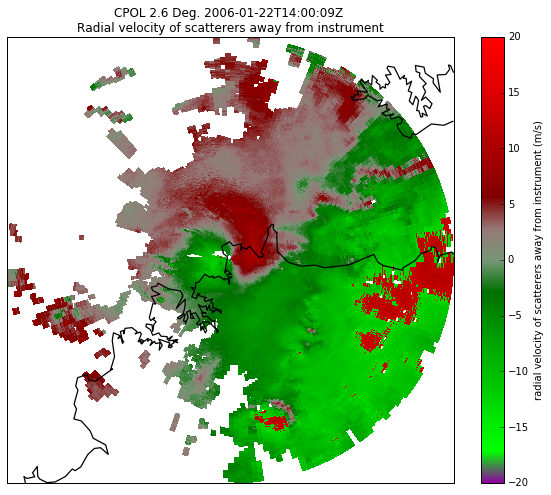

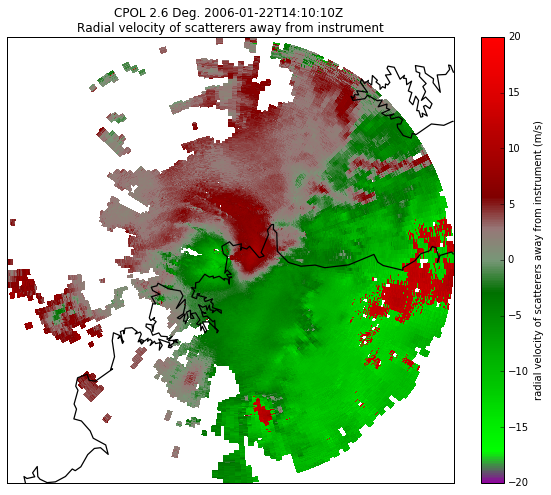

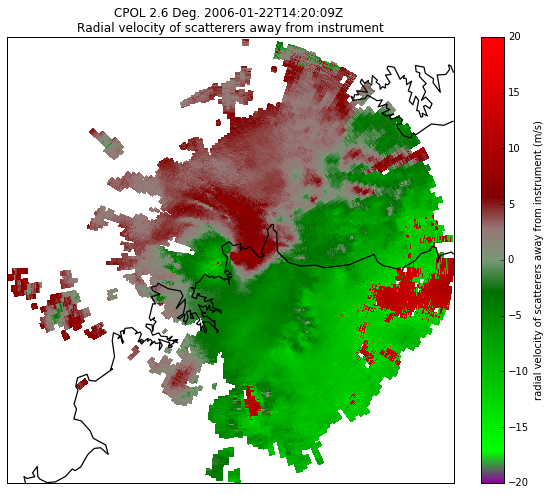

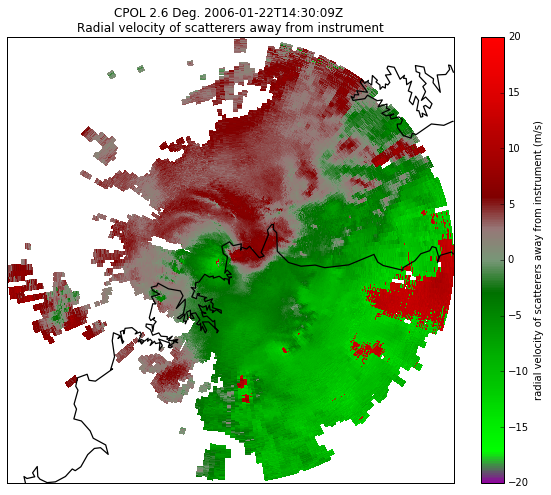

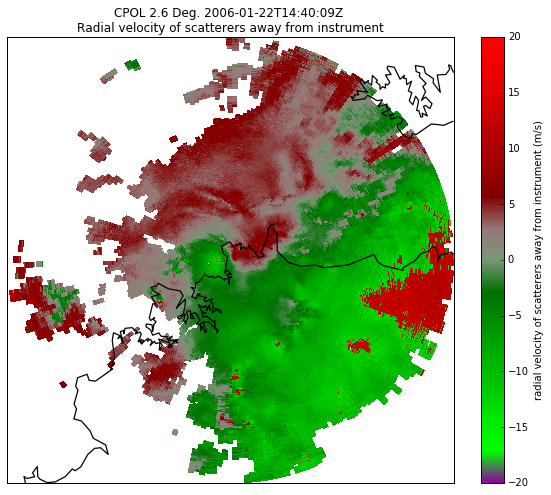

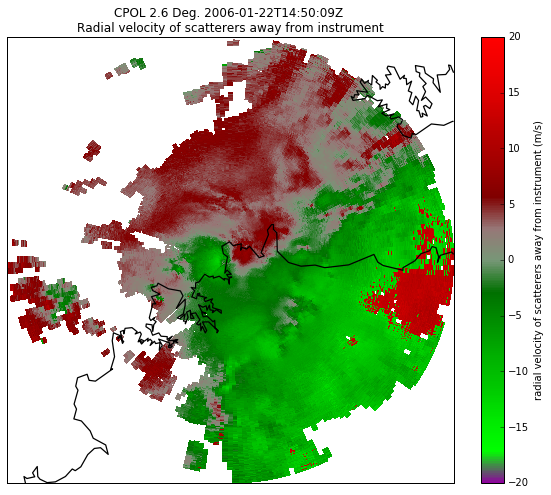

In [12]:
#Plotting the raw velocity data.
#Saving each plot as a png
for radar_file in radar_files:
    out_path1 = '/home/zsherman/Documents/Jupyter/CSU_unfolded/Images/Velocity/'
    display = pyart.graph.RadarMapDisplay(radar_file)
    fig = plt.figure(figsize = [10,8])
    display.plot_ppi_map('velocity', sweep = 3, resolution = 'i',
                        vmin = -1.5*ny_vel, vmax = 1.5*ny_vel, mask_outside = False,
                        cmap = pyart.graph.cm.NWSVel)
    out_file1 = out_path1 + os.path.basename(filename).split('.', 1)[0]+ '_el%.0f' % (el_sel) + '_velocity.png'
    plt.savefig(out_file1)

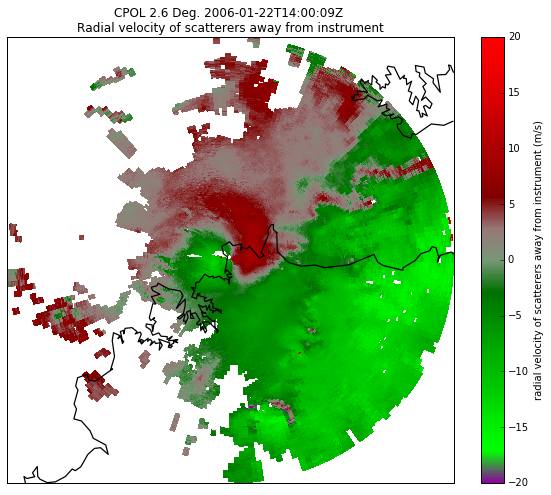

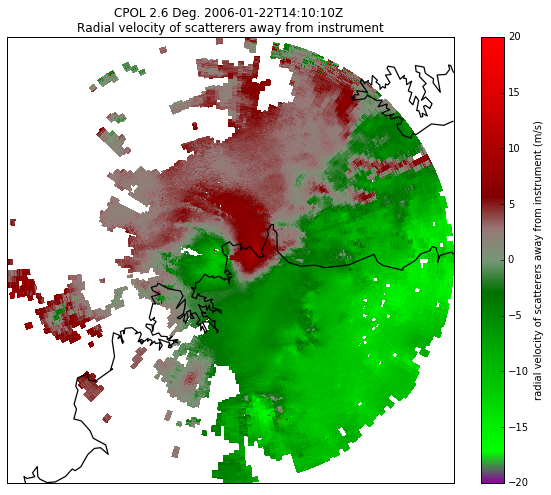

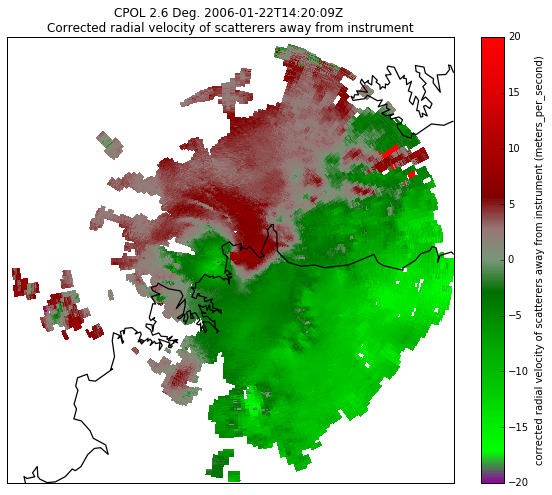

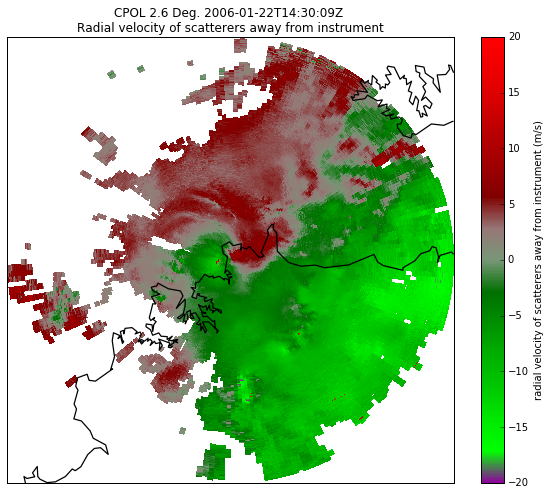

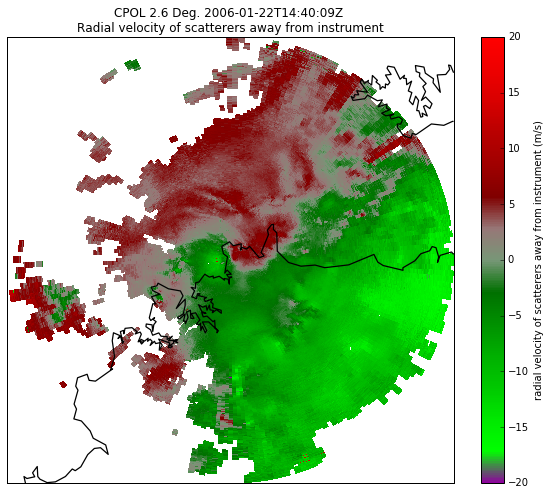

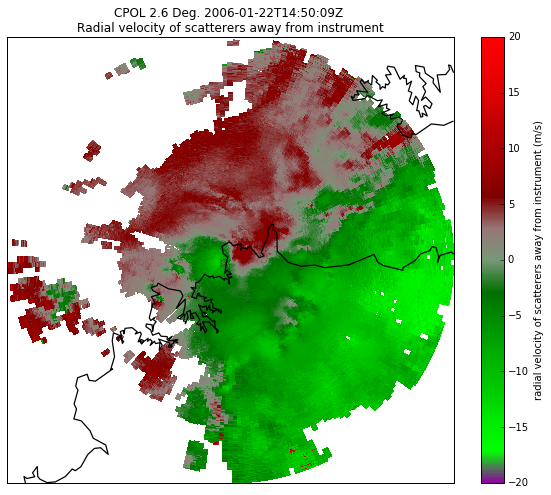

In [13]:
#Plotting the hand-dealiased velocity data.
#Radar file 2 has the hand-dealiased data as the field 'corrected_velocity2' instead of corrected_velocity.
#Saving each plot as a png
for radar_file in radar_files:
    out_path2 = '/home/zsherman/Documents/Jupyter/CSU_unfolded/Images/Hand_Corrected_Velocity/'
    cv_attribute_name = ''
    if ('corrected_velocity' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity'
    elif ('corrected_velocity2' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity2'
    else:
        raise Exception('key not found')
    display = pyart.graph.RadarMapDisplay(radar_file)
    fig = plt.figure(figsize = [10,8])
    display.plot_ppi_map(cv_attribute_name, sweep = 3, resolution = 'i',
                        vmin = -1.5*ny_vel, vmax = 1.5*ny_vel, mask_outside = False,
                        cmap = pyart.graph.cm.NWSVel)

    out_file2 = out_path2 + os.path.basename(filename).split('.', 1)[0]+ '_el%.0f' % (el_sel) + 'hand_corrected_velocity.png'
    plt.savefig(out_file2)
   

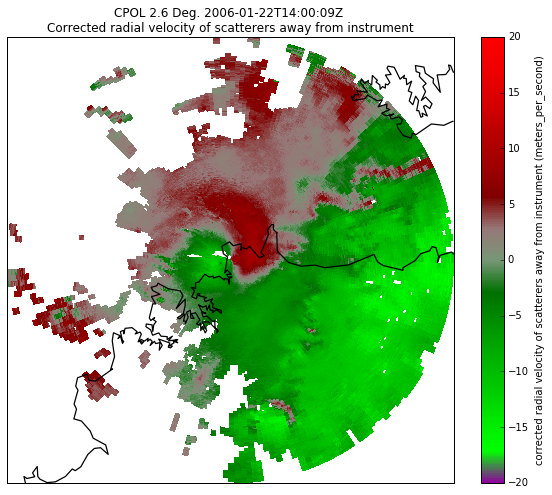

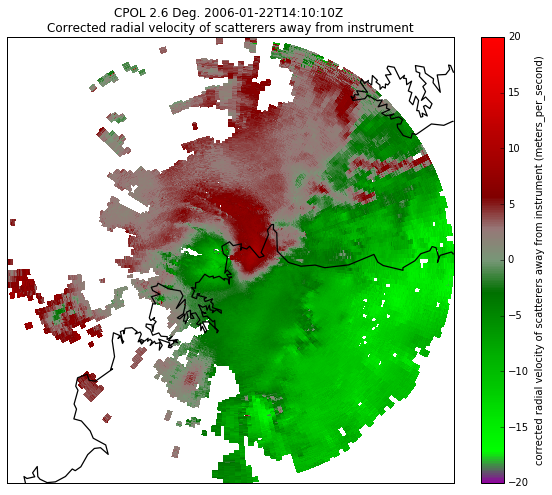

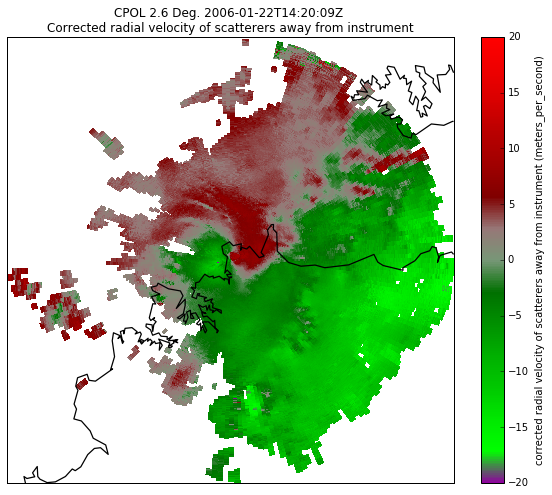

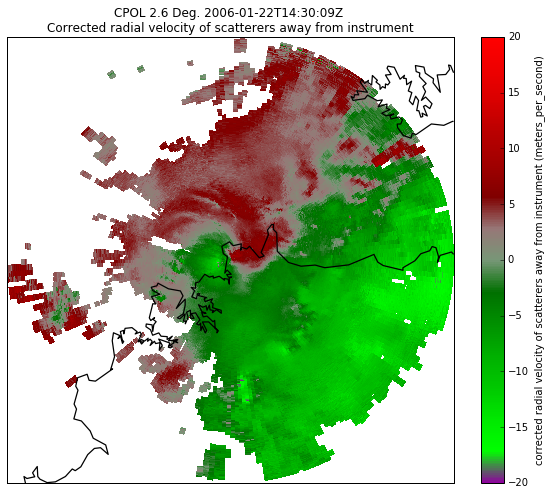

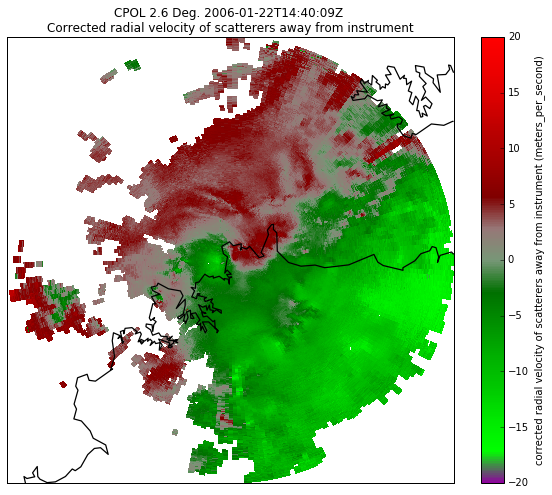

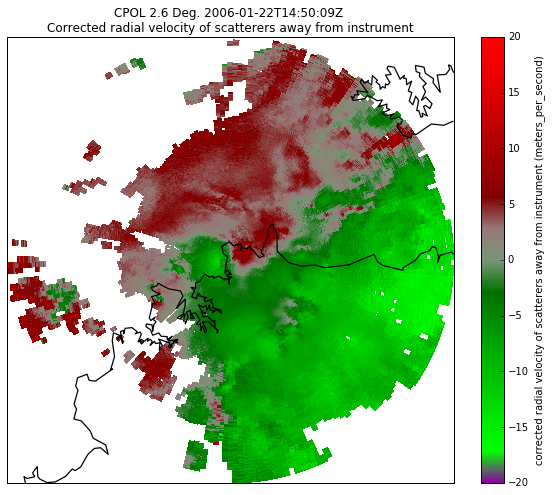

In [14]:
#Plotting corrected_velocity pyart region corrected.
#Saving each plot as a png
for radar_file in radar_files:
    corrected_velocity_region(radar_file)
    out_path3 = '/home/zsherman/Documents/Jupyter/CSU_unfolded/Images/Region_Corrected_Velocity/'
    display = pyart.graph.RadarMapDisplay(radar_file)
    fig = plt.figure(figsize = [10,8])
    display.plot_ppi_map('corrected_velocity_region', sweep = 3, resolution = 'i',
                        vmin = -1.5*ny_vel, vmax = 1.5*ny_vel, mask_outside = False,
                        cmap = pyart.graph.cm.NWSVel)
    out_file3 = out_path3 + os.path.basename(filename).split('.', 1)[0]+ '_el%.0f' % (el_sel) + 'region_corrected_velocity.png'
    plt.savefig(out_file3)